ID: V01053626

Name: Newsha Bahardoost

In [3]:
import sqlite3
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
import time
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.linalg import pinv

# Task 1: Matrix Extraction
conn = sqlite3.connect('/content/enron.db')
query = """
SELECT m.date, m.sender, r.rvalue as recipient
FROM Message m
JOIN RecipientInfo r ON m.mid = r.mid
WHERE m.sender LIKE '%@enron.com' AND r.rvalue LIKE '%@enron.com'
"""
df = pd.read_sql_query(query, conn)
conn.close()

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df['month'] = df['date'].dt.to_period('M').astype(str)

grouped = df.groupby('month')
matrices = []

for month, group in grouped:
    pairs = group[['sender', 'recipient']].drop_duplicates()
    if pairs.empty:
        continue
    senders = pairs['sender'].unique()
    recipients = pairs['recipient'].unique()
    sender_idx = {s: i for i, s in enumerate(senders)}
    recipient_idx = {r: i for i, r in enumerate(recipients)}
    rows = [sender_idx[s] for s in pairs['sender']]
    cols = [recipient_idx[r] for r in pairs['recipient']]
    data = np.ones(len(rows), dtype=np.int8)
    matrix = coo_matrix((data, (rows, cols)), shape=(len(senders), len(recipients))).tocsr()
    nnz = matrix.nnz
    sparsity = (1 - (nnz / (len(senders) * len(recipients)))) * 100
    matrices.append({
        'month': month,
        'matrix': matrix,
        'rows': len(senders),
        'cols': len(recipients),
        'nnz': nnz,
        'sparsity': sparsity
    })

matrices.sort(key=lambda x: x['rows'] * x['cols'], reverse=True)
top_matrices = matrices[:10]

for mat in top_matrices:
    print(f"month='{mat['month']}'; dim={mat['rows']}x{mat['cols']}; items={mat['nnz']}; sparsity={mat['sparsity']:.1f}")

month='2001-10'; dim=1947x7194; items=35474; sparsity=99.7
month='2001-11'; dim=1723x6394; items=31394; sparsity=99.7
month='2001-05'; dim=1540x6595; items=29694; sparsity=99.7
month='2001-06'; dim=1136x5885; items=21689; sparsity=99.7
month='2001-09'; dim=1097x5836; items=20037; sparsity=99.7
month='2001-04'; dim=1082x4606; items=17812; sparsity=99.6
month='2000-11'; dim=1038x4785; items=18690; sparsity=99.6
month='2000-12'; dim=1098x4355; items=16660; sparsity=99.7
month='2001-08'; dim=914x4518; items=15298; sparsity=99.6
month='2001-03'; dim=889x3797; items=15555; sparsity=99.5


In [4]:
# Task 2: SVD
svd_results = []
for mat in top_matrices:
    matrix = mat['matrix']
    month = mat['month']
    m, n = matrix.shape
    M_dense = matrix.toarray()
    start_time = time.time()
    U, S, Vt = np.linalg.svd(M_dense, full_matrices=False)
    svd_time = time.time() - start_time
    total_energy = np.sum(S**2)
    energy_target = 0.9 * total_energy
    cumulative_energy = np.cumsum(S**2)
    k = np.argmax(cumulative_energy >= energy_target) + 1
    U_k = U[:, :k]
    S_k = S[:k]
    Vt_k = Vt[:k, :]
    M_hat = U_k @ np.diag(S_k) @ Vt_k
    error = np.linalg.norm(M_dense - M_hat, 'fro')
    svd_size = U_k.size + S_k.size + Vt_k.size
    svd_results.append({
        'month': month,
        'k': k,
        'svd_time': svd_time,
        'error': error,
        'svd_size': svd_size
    })

for mat, res in zip(top_matrices, svd_results):
    print(f"month='{mat['month']}'; dim={mat['rows']}->{res['k']}; svd_time={res['svd_time']:.1f}; svd_err={res['error']:.0f}; svd_size={res['svd_size']}")

month='2001-10'; dim=1947->475; svd_time=21.5; svd_err=60; svd_size=4342450
month='2001-11'; dim=1723->403; svd_time=14.2; svd_err=56; svd_size=3271554
month='2001-05'; dim=1540->335; svd_time=28.5; svd_err=54; svd_size=2725560
month='2001-06'; dim=1136->260; svd_time=7.2; svd_err=46; svd_size=1825720
month='2001-09'; dim=1097->267; svd_time=5.8; svd_err=45; svd_size=1851378
month='2001-04'; dim=1082->272; svd_time=3.9; svd_err=42; svd_size=1547408
month='2000-11'; dim=1038->272; svd_time=5.5; svd_err=43; svd_size=1584128
month='2000-12'; dim=1098->314; svd_time=3.9; svd_err=41; svd_size=1712556
month='2001-08'; dim=914->233; svd_time=2.8; svd_err=39; svd_size=1265889
month='2001-03'; dim=889->233; svd_time=2.8; svd_err=39; svd_size=1092071


In [5]:
# Task 3: CUR
cur_results = []
for mat, res in zip(top_matrices, svd_results):
    month = mat['month']
    matrix = mat['matrix']
    k = res['k']
    m, n = matrix.shape
    np.random.seed(19)
    start_time = time.time()

    # Column selection
    M_csc = matrix.tocsc()
    col_norms = np.array(M_csc.power(2).sum(axis=0)).flatten()
    total_F = col_norms.sum()
    p_cols = col_norms / total_F
    selected_cols = np.random.choice(n, size=k, p=p_cols)
    scaling_cols = 1.0 / np.sqrt(k * p_cols[selected_cols])
    C = matrix[:, selected_cols].toarray() * scaling_cols

    # Row selection
    M_csr = matrix.tocsr()
    row_norms = np.array(M_csr.power(2).sum(axis=1)).flatten()
    p_rows = row_norms / total_F
    selected_rows = np.random.choice(m, size=k, p=p_rows)
    scaling_rows = 1.0 / np.sqrt(k * p_rows[selected_rows])
    R = matrix[selected_rows, :].toarray() * scaling_rows.reshape(-1, 1)

    # Compute W and pseudoinverse
    W = matrix[selected_rows, :][:, selected_cols].toarray()
    U_cur = pinv(W)
    cur_time = time.time() - start_time

    M_hat_cur = C @ U_cur @ R
    error = np.linalg.norm(matrix.toarray() - M_hat_cur, 'fro')
    cur_size = C.size + U_cur.size + R.size
    cur_results.append({
        'month': month,
        'cur_time': cur_time,
        'error': error,
        'cur_size': cur_size
    })

for mat, res in zip(top_matrices, cur_results):
    print(f"month='{mat['month']}'; dim={mat['rows']}->{svd_results[top_matrices.index(mat)]['k']}; cur_time={res['cur_time']:.1f}; cur_err={res['error']:.0f}; cur_size={res['cur_size']}")


month='2001-10'; dim=1947->475; cur_time=0.2; cur_err=3568; cur_size=4567600
month='2001-11'; dim=1723->403; cur_time=0.1; cur_err=1448; cur_size=3433560
month='2001-05'; dim=1540->335; cur_time=0.1; cur_err=1969; cur_size=2837450
month='2001-06'; dim=1136->260; cur_time=0.0; cur_err=972; cur_size=1893060
month='2001-09'; dim=1097->267; cur_time=0.1; cur_err=725; cur_size=1922400
month='2001-04'; dim=1082->272; cur_time=0.0; cur_err=786; cur_size=1621120
month='2000-11'; dim=1038->272; cur_time=0.1; cur_err=693; cur_size=1657840
month='2000-12'; dim=1098->314; cur_time=0.1; cur_err=1067; cur_size=1810838
month='2001-08'; dim=914->233; cur_time=0.0; cur_err=682; cur_size=1319945
month='2001-03'; dim=889->233; cur_time=0.1; cur_err=534; cur_size=1146127


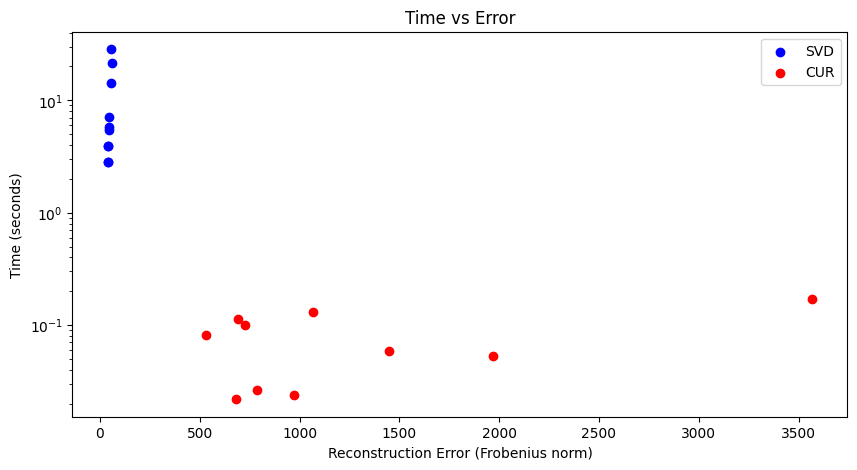

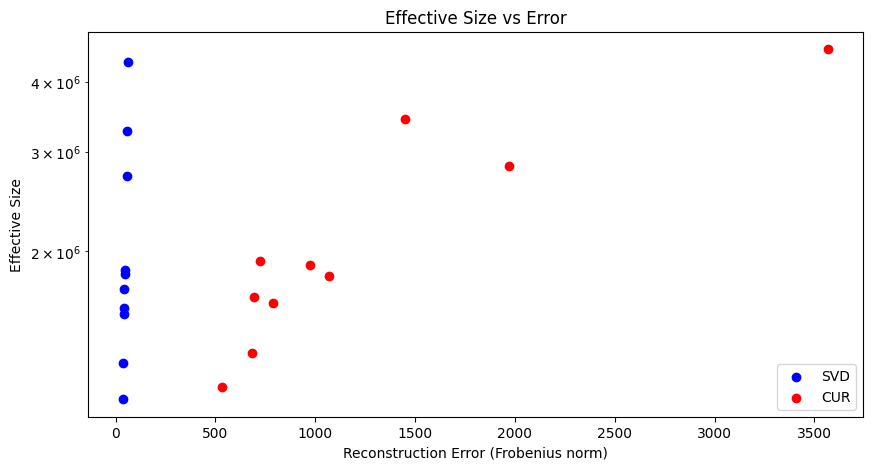

In [6]:
# Task 4: Comparison Plots
svd_errs = [res['error'] for res in svd_results]
svd_times = [res['svd_time'] for res in svd_results]
svd_sizes = [res['svd_size'] for res in svd_results]
cur_errs = [res['error'] for res in cur_results]
cur_times = [res['cur_time'] for res in cur_results]
cur_sizes = [res['cur_size'] for res in cur_results]

plt.figure(figsize=(10, 5))
plt.scatter(svd_errs, svd_times, label='SVD', color='blue')
plt.scatter(cur_errs, cur_times, label='CUR', color='red')
plt.xlabel('Reconstruction Error (Frobenius norm)')
plt.ylabel('Time (seconds)')
plt.yscale('log')
plt.legend()
plt.title('Time vs Error')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(svd_errs, svd_sizes, label='SVD', color='blue')
plt.scatter(cur_errs, cur_sizes, label='CUR', color='red')
plt.xlabel('Reconstruction Error (Frobenius norm)')
plt.ylabel('Effective Size')
plt.yscale('log')
plt.legend()
plt.title('Effective Size vs Error')
plt.show()